# Comparing Random Forest vs. 3D NN vs. Human Prediction

In [23]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

from typing import Sequence
import jax.numpy as jnp
import numpy as np
import jax
import optax
import flax.linen as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #otherwise OOM sometimes on gpu

In [24]:
# load cleaned data
fpath = '../cleaned_dataset_10mins/outputs/shifted_table.fits'
from astropy.table import Table
dat = Table.read(fpath, format='fits')
cleaned = dat.to_pandas()
cleaned.dropna(axis=0,inplace=True)
# copy the air_temp column shifted forward one obsday in a new column called 'air_temp_nextday'
shifted_full = cleaned.copy()
shifted_full['air_temp_nextday'] = cleaned['air_temp'].shift(-1)
shifted_full['des_temp_nextday'] = cleaned['adjusted_desired_temp'].shift(-1)
# Remove the first and last rows
shifted_full = shifted_full.iloc[1:-1].dropna()
shifted_full

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp,air_temp_nextday,des_temp_nextday
1,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,b'2021-09-16',18.0,20.452457,18.0
2,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,b'2021-09-17',18.0,19.840065,18.0
3,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,b'2021-09-18',18.0,19.801253,18.0
4,0.820000,18.435370,793.885757,56.468469,14.201635,169.605956,18.239396,19.801253,0.144727,1.745180,0.849827,473.589945,49.491711,2375.040069,0.114214,2.293055,b'2021-09-19',18.0,19.573302,18.0
5,1.000000,18.440468,796.016577,41.931388,11.936491,224.588630,17.995493,19.573302,0.000000,1.162407,1.556882,23.431062,21.559366,2688.718538,0.002478,0.694363,b'2021-09-20',18.0,20.367720,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1.000000,-2.022445,795.000000,34.049291,19.899718,131.787030,-0.009532,0.263017,0.000000,9.148258,0.000000,245.372451,106.247777,3414.162997,0.016121,2.378200,b'2023-02-16',-3.0,4.533253,4.0
410,1.000000,4.533968,795.000000,23.233633,29.736987,107.191097,0.763877,4.533253,0.000000,2.514957,0.000000,32.061395,180.518908,167.256263,0.364793,1.523822,b'2023-02-17',4.0,7.790498,4.0
411,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,b'2023-02-18',4.0,7.350313,4.0
412,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,b'2023-02-19',4.0,7.895247,4.0


### Flax NN boilerplate with appropriate dimensionality to predict Y from X


In [25]:
#Training functions

# This is a training function that doesn't use biases in the last layer
class MLP(nn.Module):
  features: Sequence[int]
  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1],use_bias=False)(x)
    return x

# This is a trianing function that does use biases in the last layer
class MLP_LL(nn.Module):
  features: Sequence[int]
  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.tanh(nn.Dense(self.features[-1],use_bias=True)(x))
    return x

# Returns the mean squared difference between predictions and actual values 
def loss_out(params, batch,model):
    features, target = batch
    preds = model.apply(params, features)
    return optax.l2_loss(preds, target).mean()

def normalize(data,scales):
    x_data,y_data = data
    return (x_data-scales['x_mean'])/scales['x_std'],(y_data-scales['y_mean'])/scales['y_std']
def unnormalize_y(data,scales):
    _,y_data = data
    return y_data*scales['y_std']+scales['y_mean']

def run_sgd(dataset,model,pars,batch_size,nn_seed=0,
            num_epochs=10_000,learning_rate = 1e-3,beta1=0.9,beta2=0.999,
            adam=True,do_batch=False,scales={},norm=False):
    # start where we ended up before
    x_data,y_data = dataset
    n_batch = y_data.shape[0]
    params = jax.jit(model.init)(jax.random.PRNGKey(nn_seed), x_data[0]) if pars is None else pars
    x_mean,y_mean = x_data.mean(axis=0),y_data.mean(axis=0)
    x_std,y_std = x_data.std(axis=0),y_data.std(axis=0)
    scales['x_mean'] = x_mean
    scales['x_std'] = x_std
    scales['y_mean'] = y_mean
    scales['y_std'] = y_std
    dataset_train = normalize(dataset,scales) if norm else dataset
    tx = optax.adam(learning_rate,beta1,beta2) if adam else optax.sgd(learning_rate,beta1)
    opt_state = tx.init(params)

    @jax.jit
    def loss(params, batch):
        # print('batch', batch)
        features, target = batch
        preds = model.apply(params, features)
        return optax.l2_loss(preds, target).mean()

    @jax.jit
    def train_step(params, opt_state, batch):
        grads = jax.grad(loss)(params, batch)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # restructure the data into batches
    if(do_batch):
        X_train, Y_train = dataset_train
        ds_train = [(X_train[i*batch_size:(i+1)*batch_size,:], 
                    Y_train[i*batch_size:(i+1)*batch_size,:]) for i in range(n_batch)]
        ds_train.append((X_train[n_batch*batch_size:,:],
                        Y_train[n_batch*batch_size:,:]))
    else:
        ds_train = dataset_train
    def train(params, opt_state, ds_train,num_epochs,do_batch=False):
        losses,epoch_params = [],[]
        for epoch in tqdm(range(num_epochs)):
            if(do_batch):
                for i,batch in enumerate(ds_train):
                    params, opt_state = train_step(params, opt_state, batch)
            else:
                params, opt_state = train_step(params, opt_state, ds_train)
            losses.append(loss(params, dataset_train)) # we can do this since we have a small dataset
            epoch_params.append(params)
        return params, opt_state,losses,epoch_params
    trained_params, trained_opt_state,losses,epoch_params = train(params, opt_state, ds_train,num_epochs=num_epochs)
    # Summary
    best_idx = np.argmin(losses)
    best_params = epoch_params[best_idx]
    logp = losses[best_idx] #save the best, even though only saving every epoch
    return model,best_params,logp,losses,scales

def train_flax(dataset,pars=None,m=16,n_batch=40):
    #train network
    d_out = dataset[1].shape[1]
    model = MLP([m,m,d_out]) 
    nn_surro, nn_w,logp,losses,scales_test = run_sgd(dataset, model,pars,batch_size=1,
                                                     num_epochs=1_000,learning_rate = 1e-2,beta1=0.9,beta2=0.999,
                                                    adam=True,do_batch=False,norm=False,nn_seed=0)
    return nn_surro, nn_w,logp,losses,scales_test
        
# Let's add a 50/50 train/test split function
import random
def split_rows_randomly(x):
    # Set random seed 
    random.seed(42)
    
    # Create a list of row indices
    rows = list(range(x))
    
    # Shuffle the row indices
    random.shuffle(rows)
    
    # Calculate the number of rows for each array
    half_rows = x // 2
    
    # Split the shuffled row indices into two arrays
    array1 = rows[:half_rows]
    array2 = rows[half_rows:]
    
    return array1, array2


## 3D Neural Network

  0%|          | 0/1000 [00:00<?, ?it/s]

median absolute deviation: 1.0232096


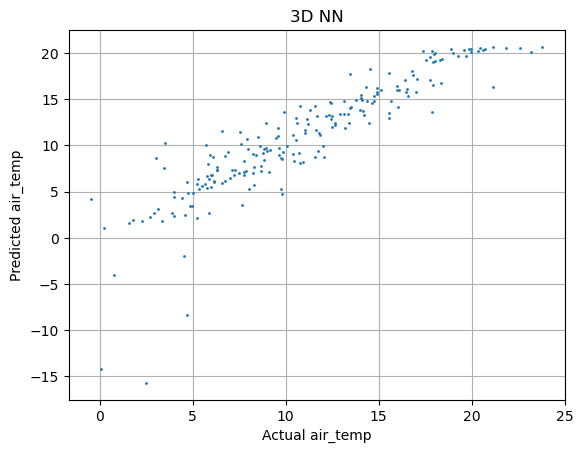

In [39]:
train_idx = split_rows_randomly(shifted_full.shape[0])[0]
test_idx = split_rows_randomly(shifted_full.shape[0])[1]

train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['temperature']),
                                jnp.array(shifted_full.iloc[train_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp'])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['temperature']),
                                jnp.array(shifted_full.iloc[test_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp'])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)

pred_3d_nn = nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0]
actu_3d_nn = shifted_full.iloc[test_idx]['air_temp_nextday']

plt.plot(shifted_full.iloc[test_idx]['air_temp_nextday'],nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0], '.', ms=2, label='NN')
plt.grid()
plt.xlabel('Actual air_temp')
plt.ylabel('Predicted air_temp')
plt.title('3D NN')
#print('median absolute deviation:', np.median(np.abs((pred_3d_nn - actu_3d_nn))))

# 3D Random Forest Trained on Same Features

In [35]:
features = ['air_temp', 'temperature', 'adjusted_desired_temp']
X = np.column_stack([shifted_full[features].values])
y = np.ravel(np.column_stack([shifted_full['air_temp_nextday']]))

regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
regrf.fit(X[train_idx], y[train_idx])
pred_rf = regrf.predict(X[test_idx])
actu_rf = y[test_idx]

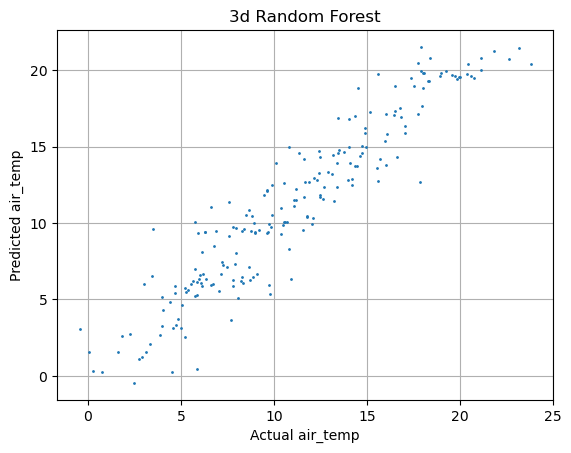

median absolute deviation: 1.0232096


In [36]:
plt.plot(actu_rf,pred_rf, '.', ms=2, label='NN')
plt.grid()
plt.xlabel('Actual air_temp')
plt.ylabel('Predicted air_temp')
plt.title('3d Random Forest')
plt.show()
print('median absolute deviation:', np.median(np.abs((pred_3d_nn - actu_3d_nn))))

# Human Prediction (adjusted_desired_temp)

In [6]:
pred_h = shifted_full.iloc[test_idx]['adjusted_desired_temp']
actu_h = shifted_full.iloc[test_idx]['air_temp_nextday']

# Comparison Plots

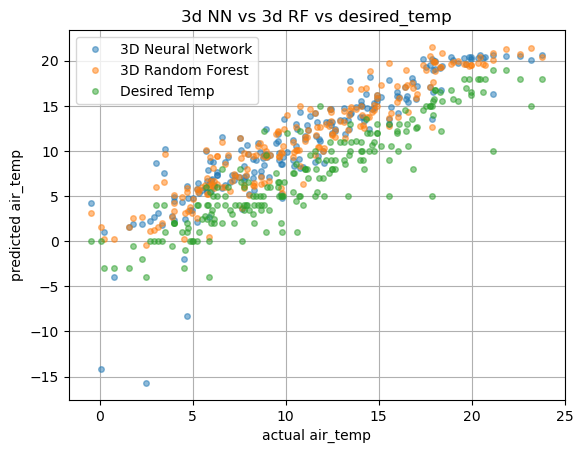

In [40]:
plt.plot(actu_3d_nn,pred_3d_nn, '.', ms=8, alpha = 0.5, label='3D Neural Network')
plt.plot(actu_rf, pred_rf, '.', ms=8, alpha = 0.5, label='3D Random Forest')
plt.plot(actu_h, pred_h, '.', ms=8, alpha = 0.5, label='Desired Temp')
plt.grid()
plt.xlabel('Actual air_temp')
plt.ylabel('Predicted air_temp')
plt.title('3D NN vs 3D RF vs desired_temp')
plt.legend()
plt.show()

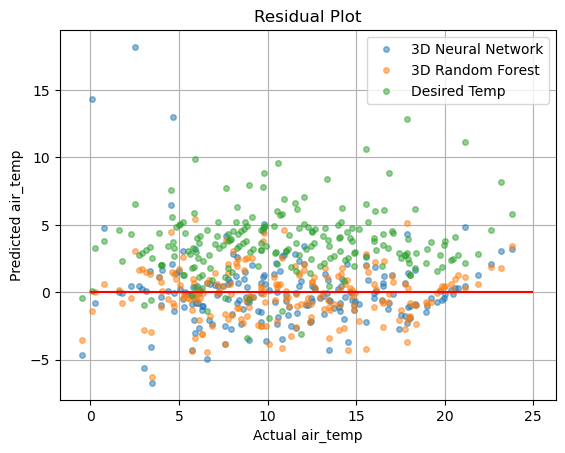

In [8]:
# Residual Plot
plt.plot(actu_3d_nn, actu_3d_nn - pred_3d_nn, '.', ms=8, alpha = 0.5, label='3D Neural Network')
plt.plot(actu_rf, actu_rf-pred_rf, '.', ms=8, alpha = 0.5, label='3D Random Forest')
plt.plot(actu_h, actu_h-pred_h, '.', ms=8, alpha = 0.5, label='Desired Temp')
plt.grid()
plt.hlines(0, 0, 25, colors='red')
plt.xlabel('Actual air_temp')
plt.ylabel('Predicted air_temp')
plt.title('Residual Plot')
plt.legend()

In [9]:
print('NN MAD:', np.median(np.abs((pred_3d_nn - actu_3d_nn))))
print('RF MAD:', np.median(np.abs((pred_rf - actu_rf))))
print('Desired Temp MAD:', np.median(np.abs((pred_h - actu_h))))

NN MAD: 1.0232096
RF MAD: 1.1070815243895051
Desired Temp MAD: 3.429297848877912


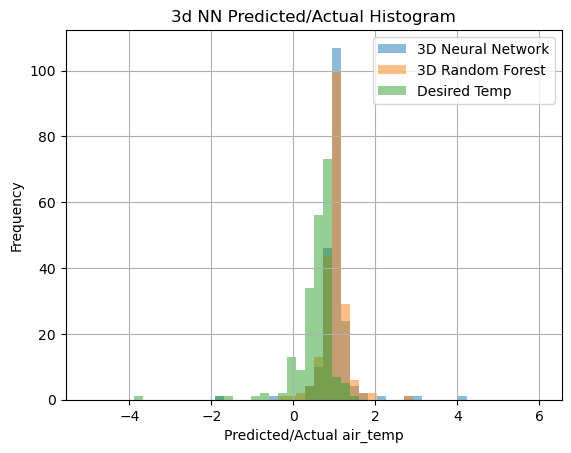

In [10]:
desired_range=(-5, 6)
plt.hist(pred_3d_nn/actu_3d_nn, bins=50, label='3D Neural Network', range=desired_range, alpha=0.5)
plt.hist(pred_rf/actu_rf, bins=50, label='3D Random Forest', range=desired_range, alpha=0.5)
plt.hist(pred_h/actu_h, bins=50, label='Desired Temp', range=desired_range, alpha=0.5)
plt.grid()
plt.xlabel('Predicted/Actual air_temp')
plt.ylabel('Frequency')
plt.title('3d NN Predicted/Actual Histogram')
plt.legend()

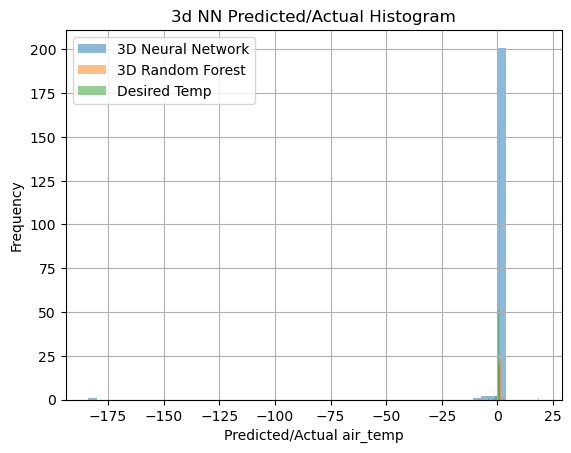

In [11]:
plt.hist(pred_3d_nn/actu_3d_nn, bins=50, label='3D Neural Network', alpha=0.5)
plt.hist(pred_rf/actu_rf, bins=50, label='3D Random Forest', alpha=0.5)
plt.hist(pred_h/actu_h, bins=50, label='Desired Temp', alpha=0.5)
plt.grid()
plt.xlabel('Predicted/Actual air_temp')
plt.ylabel('Frequency')
plt.title('3d NN Predicted/Actual Histogram')
plt.legend()

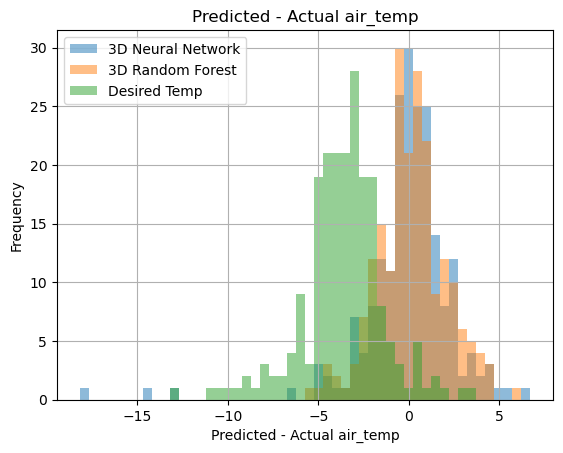

In [46]:
all_data = np.concatenate([pred_3d_nn-actu_3d_nn, pred_rf-actu_rf, pred_h-actu_h])
num_bins = 50  # Choose an appropriate number of bins
bin_edges = np.linspace(np.min(all_data), np.max(all_data), num_bins + 1)

plt.hist(pred_3d_nn-actu_3d_nn, bins=bin_edges, label='3D Neural Network', alpha=0.5)
plt.hist(pred_rf-actu_rf, bins=bin_edges, label='3D Random Forest', alpha=0.5)
plt.hist(pred_h-actu_h, bins=bin_edges, label='Desired Temp', alpha=0.5)
plt.grid()
plt.xlabel('Predicted - Actual air_temp')
plt.ylabel('Frequency')
plt.title('Predicted - Actual air_temp')
plt.legend()
plt.show()

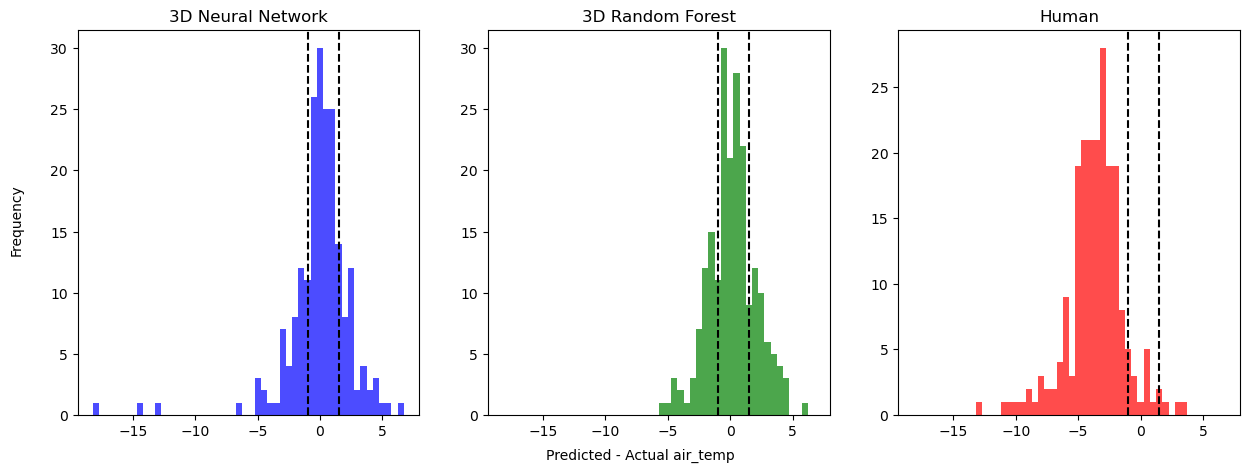

In [57]:
all_data = np.concatenate([pred_3d_nn-actu_3d_nn, pred_rf-actu_rf, pred_h-actu_h])
num_bins = 50  # Choose an appropriate number of bins
bins = np.linspace(np.min(all_data), np.max(all_data), num_bins + 1)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Plot the histograms on each subplot
axs[0].hist(pred_3d_nn-actu_3d_nn, bins=bins, alpha=0.7, color='blue')
axs[1].hist(pred_rf-actu_rf, bins=bins, alpha=0.7, color='green')
axs[2].hist(pred_h-actu_h, bins=bins, alpha=0.7, color='red')

# Add vertical lines at x=-1 and x=1.5
for ax in axs:
    ax.axvline(x=-1, color='black', linestyle='--')
    ax.axvline(x=1.5, color='black', linestyle='--')

# Set titles for each subplot (optional)
axs[0].set_title('3D Neural Network')
axs[1].set_title('3D Random Forest')
axs[2].set_title('Human')

# Set common x and y axis labels
fig.text(0.5, 0.02, 'Predicted - Actual air_temp', ha='center')
fig.text(0.08, 0.5, 'Frequency', va='center', rotation='vertical')

# Show the plot
#plt.tight_layout()
plt.show()

In [63]:
# Filter values within the range -1 to 1.5
array=pred_h-actu_h
filtered_values = array[(array >= -1) & (array <= 1.5)]

# Calculate the percentage
percentage = (len(filtered_values) / len(array)) * 100
print(percentage)

6.763285024154589
